In [1]:
import numpy as np
import scipy.fftpack
from scipy import ndimage
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
import os

In [2]:
data=pd.read_table('datos.txt')#Change01
nom_reg = '604'
nom_lin = 'Halpha'
pc=4.16 #If X and Y are in arcsec change for parsecs
#rs=0.01

In [3]:
#m=(data.X<145)&(data.X>60)#change to Headers name
#data=data[m]
data.describe()

,X,Y,RV
count,330.000000,330.000000,330.000000
mean,107.280000,9.390000,-275.757688
std,12.788265,6.260324,9.697986
min,85.824000,0.000000,-296.649181
25%,96.552000,4.000000,-282.613847
50%,107.280000,9.000000,-276.070115
75%,118.008000,15.000000,-270.394313
max,128.736000,19.600000,-231.143341


Bidimensional Data

(0.0, 33.0, 0.0, 10.0)

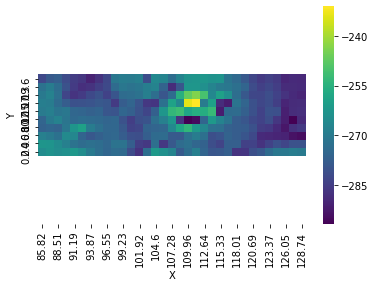

In [4]:
sig2=2*(data.RV.var())#Change to header
data_2=(data.round(2)).pivot(index='Y', columns='X', values='RV')#Change to header
sns.heatmap(data_2, cmap="viridis")
plt.gca().invert_yaxis()
plt.axis('equal')

Data Re arrange

In [5]:
df1=abs(data)
df1n=df1.to_numpy()

xl=[row[0] for row in df1n]
yl=[row[1] for row in df1n]
fl=[row[2] for row in df1n]

x1=[xl]
y1=[yl]
f1=[fl]

x=list(map(list, zip(*x1)))
y=list(map(list, zip(*y1)))
f=list(map(list, zip(*f1)))

Autocorrelation Function

In [6]:
fm=np.nanmean(f)
fv=np.nanvar(f,ddof=1)
fs=np.nanstd(f,ddof=1)
l=len(f)
S=[[fm],[fv],[fs],[l]]

In [7]:
f=f-np.nanmean(f)

In [8]:
a=[[0]*(l) for i in range(l)]
b=[[0]*(l) for i in range(l)]
c=[[0]*(2) for i in range(l*l)]

#Normalized Second Order Structure Function Matrix [LxL]
for i in range(l):
    for j in range(l):
        if i > j:
            a[i][j]=(f[j][0]*f[i][0])/fv
            
#Normalized Second Order Structure Function Matrix [LxL]
#for i in range(l):
#    for j in range(l):
#        if i > j:
#            a[i][j]=(((f[j][0]-fm)*(f[i][0]-fm)))/(fv)

#Coord Matrix [LxL]
for i in range(l):
    for j in range(l):
        if i > j:
            b[i][j]=((x[i][0]-x[j][0])**2+(y[i][0]-y[j][0])**2)**0.5
            
#Main Matrix  [(L*L)x2]
for j in range (l):
    for i in range (l):
        c[i+j*(l)][1]=a[i][j]

for j in range (l):
    for i in range (l):
        c[i+j*(l)][0]=b[i][j]



In [9]:
#Filter: Greater than "0"
d=np.asarray(c)
ind=np.squeeze(d[:,0])>0
e=d[ind]
#Pandas Stuff
df=pd.DataFrame(e)
df.columns=['lag','qvd']#squared velocities difference
df.describe()

,lag,qvd
count,54285.000000,54285.000000
mean,17.753445,-0.003030
std,9.501559,0.990949
min,1.341000,-9.910167
25%,10.353411,-0.306520
50%,16.458493,-0.000517
75%,24.159951,0.316829
max,47.176263,19.949954


/home/zalenovo/my_project_dir/my_project_env/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


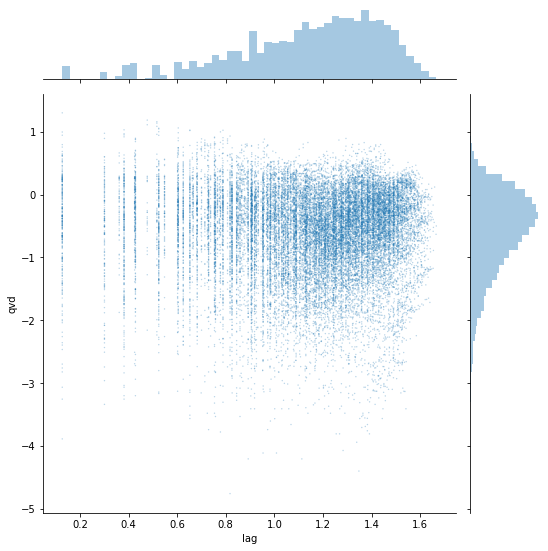

In [10]:
ax=sns.jointplot(x=np.log10(df.lag), y=np.log10(df.qvd), alpha=0.3, s=2, edgecolor='none')
ax.fig.set_size_inches(8,8)

In [11]:
#Main Filter
m=df.lag[1]-df.lag[0]#Lag step
#m=2*m
n=int(df.lag.max()//df.lag.min())-1#Number of points
#Grouping points
dfx=dict()
for i in range(n):
    p=0+i*(m+0.001)
    q=m+i*m
    dfx[i]=df[df['lag'].between(p,q)]

In [12]:
dfx

{0:          lag       qvd
 0      1.341  1.850572
 329    1.341  1.907350
 984    1.341  0.852857
 2282   1.341 -0.047171
 2604   1.341  0.072026
 ...      ...       ...
 54207  1.341  0.709778
 54240  1.341  0.009854
 54257  1.341  0.155560
 54275  1.341  1.749631
 54282  1.341  1.429184
 
 [160 rows x 2 columns], 1:             lag       qvd
 1      2.682000  1.967722
 32     2.300000  1.863589
 33     2.662383  1.818031
 360    2.662383  1.806412
 361    2.300000  1.762252
 ...         ...       ...
 54166  2.682000  0.312479
 54231  2.682000  0.007489
 54241  2.682000  0.049600
 54271  2.682000  1.359770
 54276  2.682000  1.653445
 
 [896 rows x 2 columns], 2:             lag       qvd
 34     3.533146  1.824539
 331    4.023000  1.131388
 363    3.533146  1.232326
 687    3.533146  1.920766
 691    3.533146  1.001769
 ...         ...       ...
 53791  4.023000  0.124942
 53962  4.023000  0.339718
 54077  4.023000 -0.003385
 54242  4.023000  0.120773
 54277  4.023000  1.838946
 
 

In [13]:
lgp=dict()
lpc=dict()
dl=dict()
dery=dict()
dfm=dict()
dfv=dict()
dfs=dict()
derx=dict()
dlm=dict()
dlv=dict()
dls=dict()

In [14]:

#Main Matrices Statistical Properties
for i in range(n):
    lgp[i]=(dfx[i]["lag"].max())
    lpc[i]=lgp[i]*pc
    dl[i]=len(dfx[i])#Numer of points each group
    #errorY
    dfm[i]=dfx[i]["qvd"].mean()
    dfv[i]=dfx[i]["qvd"].var()
    dfs[i]=dfx[i]["qvd"].std()
    if dl[i]>0:
        dery[i]=dfs[i]/(dl[i])**0.5
    #errorX
    dlm[i]=dfx[i]["lag"].mean()
    dlv[i]=dfx[i]["lag"].var()
    dls[i]=dfx[i]["lag"].std()
    if dl[i]>0:
        derx[i]=dls[i]/(dl[i])**0.5


g=[[0]*(8) for i in range(n)]

for i in range(n):

    g[i][0]=lgp[i]
    g[i][1]=dfm[i]
    g[i][2]=dery[i]
    g[i][3]=derx[i]
    g[i][4]=dfs[i]
    g[i][5]=dfv[i]
    g[i][6]=lpc[i]
    g[i][7]=dl[i]



In [15]:
dfx[0]

,lag,qvd
0,1.341,1.850572
329,1.341,1.907350
984,1.341,0.852857
2282,1.341,-0.047171
2604,1.341,0.072026
...,...,...
54207,1.341,0.709778
54240,1.341,0.009854
54257,1.341,0.155560
54275,1.341,1.749631


In [16]:
dfx[1].std()

lag    0.237439
qvd    1.309277
dtype: float64

In [17]:
len(dfx[0])

160

In [18]:
derx,dery

({0: 4.3987973845074227e-16,
  1: 0.007932265037957473,
  2: 0.01067650458205871,
  3: 0.008492813900608421,
  4: 0.008627681228673844,
  5: 0.008053185761528232,
  6: 0.008036257328553748,
  7: 0.006727004029823029,
  8: 0.007238206584331458,
  9: 0.007891854129307825,
  10: 0.0077273127196778825,
  11: 0.0065637883336690135,
  12: 0.007602927744267752,
  13: 0.007327862608195653,
  14: 0.00821692329363445,
  15: 0.008225744266061404,
  16: 0.00823359278263622,
  17: 0.009169139370331196,
  18: 0.010453545437982785,
  19: 0.010583998843576832,
  20: 0.010183315308618998,
  21: 0.009943935409724484,
  22: 0.010751471193543357,
  23: 0.012514690502780377,
  24: 0.013408234755028258,
  25: 0.01346520206537824,
  26: 0.014273889080431522,
  27: 0.01459072418283281,
  28: 0.017284721124772456,
  29: 0.01918563256524789,
  30: 0.021802555598918916,
  31: 0.02446060442621127,
  32: 0.0322072899972488,
  33: 0.060309977162824054},
 {0: 0.16868976384623552,
  1: 0.04373987157390646,
  2: 0.059

In [19]:
sf=pd.DataFrame(g)
sf.columns=['Lag','Nmqvd','ErrY','ErrX','StD','Var','Lag pc','# P']
sf.loc[-1]=[0,1,0,0,0,0,0,1]
sf.index=sf.index+1
sf.sort_index(inplace=True)

sf.describe()

,Lag,Nmqvd,ErrY,ErrX,StD,Var,Lag pc,# P
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,22.751958,0.005805,0.034610,0.012348,0.923479,0.965049,94.648145,1384.342857
std,13.722017,0.378380,0.033641,0.010385,0.339906,0.797296,57.083591,912.604738
min,0.000000,-0.621288,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,11.352309,-0.202122,0.019284,0.007912,0.772571,0.596872,47.225604,644.000000
50%,22.762248,-0.000961,0.021696,0.009169,0.878130,0.771113,94.690952,1284.000000
75%,34.162292,0.145084,0.035789,0.013437,1.033030,1.067640,142.115136,2211.000000
max,45.557982,1.000000,0.168690,0.060310,2.133775,4.552998,189.521206,2859.000000


In [20]:
sf

,Lag,Nmqvd,ErrY,ErrX,StD,Var,Lag pc,# P
0,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1
1,1.341000,0.989205,0.168690,4.398797e-16,2.133775,4.552998,5.578560,160
2,2.682000,0.491829,0.043740,7.932265e-03,1.309277,1.714206,11.157120,896
3,4.023000,0.438558,0.059721,1.067650e-02,1.697583,2.881787,16.735680,808
4,5.364000,0.389012,0.033784,8.492814e-03,1.294861,1.676666,22.314240,1469
5,6.691225,0.315115,0.024887,8.627681e-03,1.144815,1.310601,27.835497,2116
6,8.000000,0.200194,0.025502,8.053186e-03,1.055172,1.113388,33.280000,1712
7,9.302284,0.113328,0.019461,8.036257e-03,0.934533,0.873352,38.697503,2306
8,10.664807,0.046365,0.016645,6.727004e-03,0.842353,0.709559,44.365599,2561
9,12.039810,-0.017538,0.016808,7.238207e-03,0.880786,0.775784,50.085610,2746


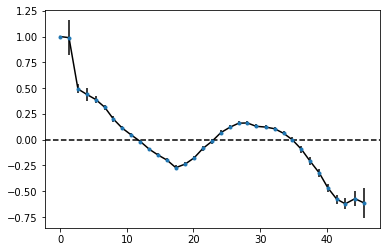

In [21]:
plt.plot(sf['Lag'],sf['Nmqvd'],color='k', alpha=1)
plt.errorbar(sf['Lag'],sf['Nmqvd'],xerr=sf.ErrX,yerr=sf.ErrY, fmt=".", ecolor='k')
plt.axhline(y=0, color='k', linestyle='--')

<ErrorbarContainer object of 3 artists>

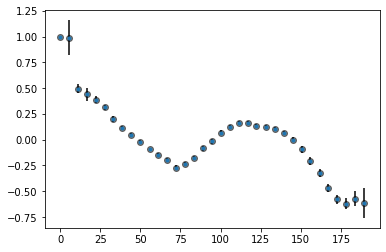

In [22]:
plt.scatter(sf['Lag pc'],sf['Nmqvd'],color='k', alpha=0.5)
plt.errorbar(sf['Lag pc'],sf['Nmqvd'],xerr=sf.ErrX,yerr=sf.ErrY, fmt=".", ecolor='k')
#plt.xscale("log")

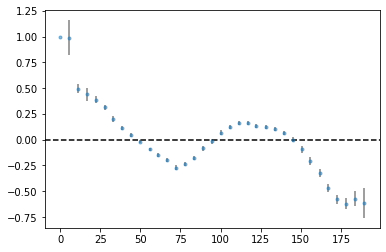

In [23]:
fig, ax=plt.subplots()
ax.errorbar(sf['Lag pc'],sf['Nmqvd'],xerr=sf.ErrX,yerr=sf.ErrY, fmt=".", ecolor='k', alpha=0.5)
ax.axhline(y=0, color='k', linestyle='--')

[(-310.0, -240.0)]

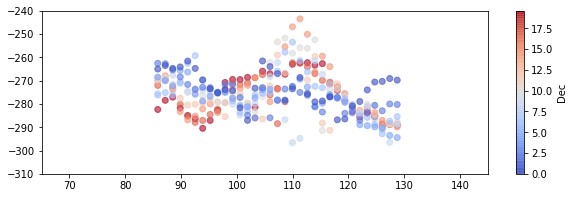

In [24]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(data.X, data.RV, c=data.Y, alpha=0.6, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")
ax.set(xlim=[65.0, 145.0])
ax.set(ylim=[-310.0, -240.0])